**OBJECTIVE:** Explore the tokens produced by BERT

**AUTHOR:** [@jonjoncardoso](https://github.com/jonjoncardoso)

**LAST UPDATED:** 24/02/2022

Content related to the article:

---
<div class="csl-entry">Andrade Junior, J. E., Cardoso-Silva, J., &#38; Bezerra, L. C. T. (2021). Comparing Contextual Embeddings for Semantic Textual Similarity in Portuguese. <i>Lecture Notes in Computer Science (Including Subseries Lecture Notes in Artificial Intelligence and Lecture Notes in Bioinformatics)</i>, <i>13074 LNAI</i>, 389–404. </div>

----

Link to download [here](https://www.researchgate.net/publication/356582885_Comparing_Contextual_Embeddings_for_Semantic_Textual_Similarity_in_Portuguese)

# Imports & Constants

In [225]:
import os
import csv
import tqdm
import math

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import xml.etree.ElementTree as et 

from datetime import datetime
from transformers import AutoTokenizer, AutoModel
from scipy.stats import pearsonr
from plotnine import *

from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer,  SentencesDataset, LoggingHandler, losses, util, InputExample
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sklearn.metrics.pairwise import  cosine_similarity

DATA_DIRECTORY = "../data/assin_data/"
DATASET_NAMES = ['assin-ptbr-train.xml', 
                 'assin-ptbr-dev.xml', 
                 'assin-ptbr-test.xml', 
                 'assin-ptpt-train.xml', 
                 'assin-ptpt-dev.xml', 
                 'assin-ptpt-test.xml']

MODEL_DIRECTORY = "../models/hugging-face-models/"
BERTIMBAU_BASE_MODEL = "neuralmind/bert-base-portuguese-cased"
BERTIMBAU_LARGE_MODEL = "neuralmind/bert-large-portuguese-cased"

In [2]:
!mkdir -p {MODEL_DIRECTORY}

# Dataset Description

The data we are using was annotated in two workshops: [ASSIN](http://propor2016.di.fc.ul.pt/?page_id=381) & [ASSIN2 workshop](https://sites.google.com/view/assin2/).

The following description comes from the ASSIN website:

> **Task Description**
>
> The ASSIN dataset contains 10,000 sentence pairs collected from Google News, half from Brazilian sources and half from Portuguese ones. 6,000 pairs are released for training and the remaining will serve as a blind test set. Each pair is annotated for both semantic relatedness and textual entailment.
>
> Semantic relatedness is measured on a scale from 1 to 5. The general guidelines for each score are:
>
>    1. Completely different sentences, on different subjects
>    1. Sentences are not related, but are roughly on the same subject
>    1. Sentences are somewhat related; they may describe different facts but share some details
>    1. Sentences are strongly related, but some details differ
>    1. Sentences mean essentially the same thing
>
> A sentence _T_ (the text) entails another sentence _H_ (the hypothesis) if, after reading both and knowing that _T_ is true, a person concludes that _H_ must also be true. ASSIN also distinguishes bidirectional entailment cases, or paraphrases.
>
>

# Data Input

The data was stored in XML format. Let us parse it as a dataframe:

In [3]:
def parse_xml(xml_file):
    
    dataset = str(os.path.basename(xml_file).replace(".xml", ""))
    
    """Parse xml to pandas dataframe."""
    xtree = et.parse(xml_file)
    xroot = xtree.getroot() 

    df_cols = ['id', 't', 'h', 'similarity', 'language', 'set']
    rows = []

    for node in xroot:
        id_ = node.attrib.get("id")
        similarity = node.attrib.get("similarity")
        t = node.find("t").text
        h = node.find("h").text

        rows.append({
            "id": int(id_),
            "t": str(t), 
            "h": str(h),
            "similarity": float(similarity),
            "language": dataset[6:10],
            "set": dataset[11:]
        })
    return pd.DataFrame(rows, columns=df_cols)

def eval_similarity(pairs_gold, pairs_sys):
    '''
    Evaluate the semantic similarity output of the system against a gold score. 
    Results are printed to stdout.
    '''
    
    gold_values = np.array(pairs_gold)
    sys_values = np.array(pairs_sys)
    pearson = pearsonr(gold_values, sys_values)[0]
    absolute_diff = gold_values - sys_values
    mse = (absolute_diff ** 2).mean()
    
    print()
    print('Similarity evaluation')
    print('Pearson\t\tMean Squared Error')
    print('-------\t\t------------------')
    print('{:7.3f}\t\t{:18.2f}'.format(pearson, mse))

In [4]:
df = pd.concat([parse_xml(os.path.join(DATA_DIRECTORY, dataset_name)) 
                for dataset_name in DATASET_NAMES])

# The **BERTimbau** models

In this notebook, we will use the **BERTimbau** models. 
- On Hugging Face, these models are referenced as ["neuralmind/bert-base-portuguese-cased"](https://huggingface.co/neuralmind/bert-base-portuguese-cased) and ["neuralmind/bert-large-portuguese-cased"](https://huggingface.co/neuralmind/bert-large-portuguese-cased)
- You can also find their models on Github: [@neuralmind-ai/portuguese-bert](https://github.com/neuralmind-ai/portuguese-bert).


The two models (Base vs Large) differ in the number of parameters their neural networks contain:

| Model | Arch. | #Layers | #Parameters |
|-|:-------------------------: |:-----------------:|:----------:|
|neuralmind/bert-base-portuguese-cased | BERT-Base | 12 | 110M|
|neuralmind/bert-large-portuguese-cased | BERT-Large | 24 | 335M|

**How did they train it?**

> BERT-Base and BERT-Large Cased variants were trained on the [BrWaC (Brazilian Web as Corpus)](https://www.researchgate.net/publication/326303825_The_brWaC_Corpus_A_New_Open_Resource_for_Brazilian_Portuguese), a large Portuguese corpus, for 1,000,000 steps, using whole-word mask. Model artifacts for TensorFlow and PyTorch can be found below.

## BERTimbau Base

**First, download then.**

There are two components to most of this kind of models: i) a Tokenizer and ii) the actual embedding model.

In [5]:
tokenizer = AutoTokenizer.from_pretrained(BERTIMBAU_BASE_MODEL)
model = AutoModel.from_pretrained(BERTIMBAU_BASE_MODEL)

Downloading:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/647 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/205k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


**Now, save those to a local repository.**

This way, you can still play with the model if you are offline or, I don't know, the authors decide to remove their models from the website or something like that.

In [6]:
tokenizer.save_pretrained(os.path.join(MODEL_DIRECTORY, BERTIMBAU_BASE_MODEL))
model.save_pretrained(os.path.join(MODEL_DIRECTORY, BERTIMBAU_BASE_MODEL))

**Now, you can load the models from the local directory directly.**

The interface is still exactly the same.

In [7]:
tokenizer = AutoTokenizer.from_pretrained(os.path.join(MODEL_DIRECTORY, BERTIMBAU_BASE_MODEL))
model = AutoModel.from_pretrained(os.path.join(MODEL_DIRECTORY, BERTIMBAU_BASE_MODEL))

## BERTimbau Large

**First, download then.**

There are two components to most of this kind of models: i) a Tokenizer and ii) the actual embedding model.

In [8]:
tokenizer = AutoTokenizer.from_pretrained(BERTIMBAU_LARGE_MODEL)
model = AutoModel.from_pretrained(BERTIMBAU_LARGE_MODEL)

Downloading:   0%|          | 0.00/155 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/648 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/205k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

Some weights of the model checkpoint at neuralmind/bert-large-portuguese-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


**Now, save those to a local repository.**

This way, you can still play with the model if you are offline or, I don't know, the authors decide to remove their models from the website or something like that.

In [9]:
tokenizer.save_pretrained(os.path.join(MODEL_DIRECTORY, BERTIMBAU_LARGE_MODEL))
model.save_pretrained(os.path.join(MODEL_DIRECTORY, BERTIMBAU_LARGE_MODEL))

**Now, you can load the models from the local directory directly.**

The interface is still exactly the same.

In [10]:
tokenizer = AutoTokenizer.from_pretrained(os.path.join(MODEL_DIRECTORY, BERTIMBAU_LARGE_MODEL))
model = AutoModel.from_pretrained(os.path.join(MODEL_DIRECTORY, BERTIMBAU_LARGE_MODEL))

# The Tokenizer

You can look at the three main types of Tokenizers used by HuggingFace on the following link: [🤗 huggingface/Summary of the tokenizers](https://huggingface.co/docs/transformers/tokenizer_summary)

Let us investigate what the tokenizer captures.

## Comparing tokens of two sentences (sim=5)

First, we will get a random sample of those sentences marked — by humans — as having similarity = 5 (the maximum).

In [52]:
sample_df = df[(df["language"] == "ptbr") & (df["similarity"] == 5)].sample(n=4, random_state=42)
sample_df.set_index(sample_df.columns.tolist())

,,,,,
id,t,h,similarity,language,set
858,"Do lado israelense, foram 73 mortos, a grande maioria de soldados.","Do lado de Israel, o conflito causou 73 mortos, quase todos soldados.",5.0,ptbr,test
820,O gaúcho presenciou três finais de Copa do Mundo e viu o Brasil levar a melhor em duas delas.,"O gaúcho presenciou três finais de Copa do Mundo, sendo duas delas vendo o Brasil sair vitorioso.",5.0,ptbr,test
218,"O Centro Geológico dos Estados Unidos (USGS) calculou a magnitude do tremor em 5,3.","O Serviço Geológico dos EUA informou que o terremoto teve magnitude 5,3.",5.0,ptbr,train
694,Conseguimos reverter os momentos de abatimento que vinham acontecendo após os gols sofridos.,"O time vinha se abatendo quando tomava um gol, e conseguimos reverter isso.",5.0,ptbr,train


In [60]:
print(f"Selected pair of sentences:\n\n   {sample_df.iloc[2]['t']}\n\n   {sample_df.iloc[2]['h']}")

Selected pair of sentences:

   O Centro Geológico dos Estados Unidos (USGS) calculou a magnitude do tremor em 5,3.

   O Serviço Geológico dos EUA informou que o terremoto teve magnitude 5,3.


### Number of words

**How many words are there in each sentence?** If I were to split on spaces:

In [76]:
print(f"Selected pair of sentences:\n\n   {sample_df.iloc[2]['t'].split()}\n   NUMBER OF WORDS: {len(sample_df.iloc[2]['t'].split())}",
      f"\n\n   {sample_df.iloc[2]['h'].split()}\n   NUMBER OF WORDS: {len(sample_df.iloc[2]['h'].split())}")

Selected pair of sentences:

   ['O', 'Centro', 'Geológico', 'dos', 'Estados', 'Unidos', '(USGS)', 'calculou', 'a', 'magnitude', 'do', 'tremor', 'em', '5,3.']
   NUMBER OF WORDS: 14 

   ['O', 'Serviço', 'Geológico', 'dos', 'EUA', 'informou', 'que', 'o', 'terremoto', 'teve', 'magnitude', '5,3.']
   NUMBER OF WORDS: 12


### Number of tokens by BERTimbau

You can find the tokens encoded by the model with the function `tokenizer.tokenize`.

In [89]:
print(f"Selected pair of sentences:\n\n   {tokenizer.tokenize(sample_df.iloc[2]['t'])}",
      f"\n   NUMBER OF TOKENS: {len(tokenizer.tokenize(sample_df.iloc[2]['t']))}",
      f"\n\n   {tokenizer.tokenize(sample_df.iloc[2]['h'])}",
      f"\n   NUMBER OF TOKENS: {len(tokenizer.tokenize(sample_df.iloc[2]['h']))}")
print()
print()


Selected pair of sentences:

   ['Nesta', 'quarta', '-', 'feira', ',', 'o', 'Cruzeiro', 'também', 'anunciou', 'a', 'renovação', 'do', 'goleiro', 'Fábio', 'por', 'mais', 'três', 'anos', '.'] 
   NUMBER OF TOKENS: 19 

   ['O', 'goleiro', 'Fábio', 'acertou', 'sua', 'permanência', 'no', 'Cruzeiro', 'por', 'mais', 'três', 'temporadas', '.'] 
   NUMBER OF TOKENS: 13




An important thing about the tokenizer above is that only a few words are subdivided into **sub-words**:

> _Subword tokenization algorithms rely on the principle that frequently used words should not be split into smaller subwords, but rare words should be decomposed into meaningful subwords._

## Comparing tokens of two sentences (sim=4)

Now, let us get a random sample of those sentences marked — by humans — as having similarity=4

In [83]:
sample_df = df[(df["language"] == "ptbr") & (df["similarity"] == 4)].sample(n=4, random_state=42)
sample_df.set_index(sample_df.columns.tolist())

,,,,,
id,t,h,similarity,language,set
1527,"Segundo a prefeitura, foram atingidos pelo incêndio mais de 150 boxes, cerca de 10% do camelódromo.","Mais de 150 boxes sofreram com o incêndio, o que representa cerca de 10% de todo o camelódromo.",4.0,ptbr,train
1936,"A dúvida, como os dois jogadores estão fora há duas semanas, é se serão titulares ou se começarão no banco.",Os dois jogadores ainda não têm presença certa no time titular.,4.0,ptbr,train
803,"Nesta quarta-feira, o Cruzeiro também anunciou a renovação do goleiro Fábio por mais três anos.",O goleiro Fábio acertou sua permanência no Cruzeiro por mais três temporadas.,4.0,ptbr,test
827,"Dentre as ocorrências, houve o registro de uma pessoa morta e outra gravemente ferida.",Uma pessoa morreu e outra ficou gravemente ferida.,4.0,ptbr,test


In [84]:
print(f"Selected pair of sentences:\n\n   {sample_df.iloc[0]['t']}\n\n   {sample_df.iloc[0]['h']}")

Selected pair of sentences:

   Segundo a prefeitura, foram atingidos pelo incêndio mais de 150 boxes, cerca de 10% do camelódromo.

   Mais de 150 boxes sofreram com o incêndio, o que representa cerca de 10% de todo o camelódromo.


### Number of words

**How many words are there in each sentence?** If I were to split on spaces:

In [88]:
print(f"Selected pair of sentences:\n\n   {sample_df.iloc[0]['t'].split()}",
      f"\n   NUMBER OF WORDS: {len(sample_df.iloc[0]['t'].split())}",
      f"\n\n   {sample_df.iloc[0]['h'].split()}",
      f"\n   NUMBER OF WORDS: {len(sample_df.iloc[0]['h'].split())}")

Selected pair of sentences:

   ['Segundo', 'a', 'prefeitura,', 'foram', 'atingidos', 'pelo', 'incêndio', 'mais', 'de', '150', 'boxes,', 'cerca', 'de', '10%', 'do', 'camelódromo.'] 
   NUMBER OF WORDS: 16 

   ['Mais', 'de', '150', 'boxes', 'sofreram', 'com', 'o', 'incêndio,', 'o', 'que', 'representa', 'cerca', 'de', '10%', 'de', 'todo', 'o', 'camelódromo.'] 
   NUMBER OF WORDS: 18


### Number of tokens by BERTimbau

You can find the tokens encoded by the model with the function `tokenizer.tokenize`.

In [90]:
print(f"Selected pair of sentences:\n\n   {tokenizer.tokenize(sample_df.iloc[0]['t'])}",
      f"\n   NUMBER OF TOKENS: {len(tokenizer.tokenize(sample_df.iloc[0]['t']))}",
      f"\n\n   {tokenizer.tokenize(sample_df.iloc[0]['h'])}",
      f"\n   NUMBER OF TOKENS: {len(tokenizer.tokenize(sample_df.iloc[0]['h']))}")
print()

Selected pair of sentences:

   ['Segundo', 'a', 'prefeitura', ',', 'foram', 'atingido', '##s', 'pelo', 'incêndio', 'mais', 'de', '150', 'boxe', '##s', ',', 'cerca', 'de', '10', '%', 'do', 'cam', '##el', '##ódromo', '.'] 
   NUMBER OF TOKENS: 24 

   ['Mais', 'de', '150', 'boxe', '##s', 'sofreram', 'com', 'o', 'incêndio', ',', 'o', 'que', 'representa', 'cerca', 'de', '10', '%', 'de', 'todo', 'o', 'cam', '##el', '##ódromo', '.'] 
   NUMBER OF TOKENS: 24



# Embeddings and Similarity

How well do the **BERTimbau** models capture the similarity of each pair of sentences?

In [92]:
from custom_transformer import BertTransformer

bert_transformer = BertTransformer(tokenizer, model)

In [93]:
t_embeddings = bert_transformer.transform(df['t'].tolist())
h_embeddings = bert_transformer.transform(df['h'].tolist())

100%|█████████████████████████████████████████████████████████████████████████████| 10000/10000 [18:37<00:00,  8.95it/s]


In [96]:
t_embeddings

tensor([[ 0.1497, -0.5899, -0.0071,  ...,  0.6452,  0.1932,  0.1936],
        [ 0.2937, -0.3182, -0.1798,  ...,  0.2410, -0.0448,  0.1491],
        [ 0.3237, -0.7698,  0.1452,  ...,  0.1810, -0.7260,  0.3845],
        ...,
        [ 0.3395, -0.6754, -0.0081,  ...,  0.1303,  0.2157,  0.2935],
        [ 0.2262, -0.1824,  0.3795,  ...,  0.6461, -0.2384,  0.1458],
        [ 0.5347, -0.4280,  0.2514,  ...,  0.7151,  0.1309,  0.3787]])

In [97]:
h_embeddings

tensor([[ 0.3926, -0.4528,  0.1510,  ...,  0.4765,  0.4975,  0.0867],
        [ 0.5527, -0.5306,  0.1012,  ...,  0.1088, -0.0935,  0.3687],
        [ 0.4501, -0.6142,  0.1870,  ...,  0.1524, -0.8975,  0.4141],
        ...,
        [ 0.4413, -0.9408, -0.1212,  ...,  0.7483, -0.2268,  0.3694],
        [ 0.2261, -0.0787,  0.3382,  ...,  0.4816, -0.0639,  0.1585],
        [ 0.0215, -0.3201,  0.0661,  ...,  0.8979, -0.6273,  0.2886]])

Let's measure the similarity between these embeddings with the cosine similarity:

In [153]:
from sklearn.metrics.pairwise import  cosine_similarity

df["bert_large_similarity"] = [5.0 * cosine_similarity([t], [h])[0][0] 
                               for t, h in zip(t_embeddings.numpy(), h_embeddings.numpy())]

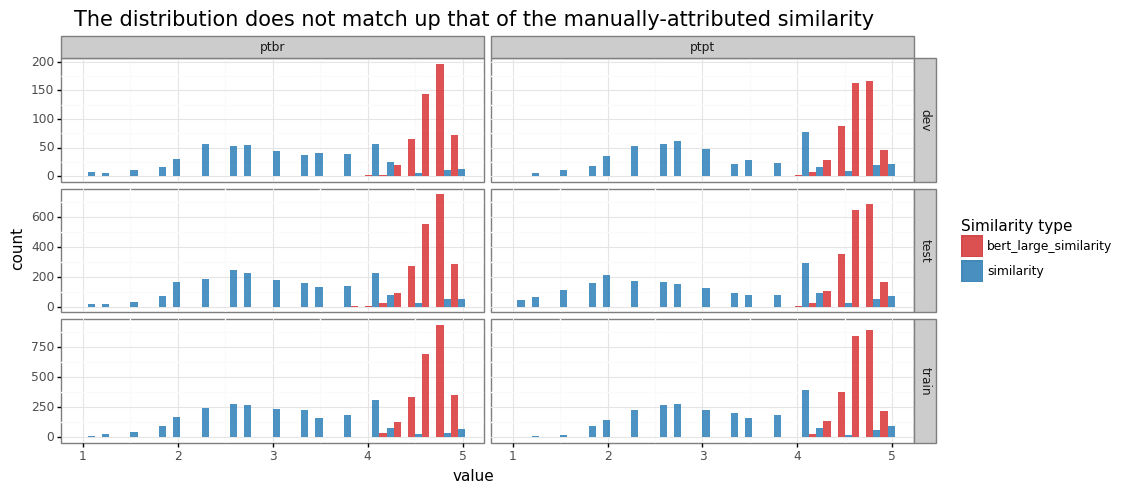

<ggplot: (8774849723642)>

In [165]:
plot_df = pd.melt(df, id_vars=["id", "t", "h", "language", "set"])

g = (ggplot(plot_df, aes(x='value', fill='variable')) +
     geom_histogram(binwidth=0.15, alpha=0.8, position="dodge") + 
     theme_bw() + 
     theme(figure_size=(11, 5),
           plot_title=element_text(size=15)) +
     scale_fill_manual(name="Similarity type", values=["tab:red", "tab:blue"]) +
     facet_grid("set ~ language", scales="free_y") +
     ggtitle("The distribution does not match up that of the manually-attributed similarity"))

g

Indeed, correlation and error metrics indicate these embeddings are not that great!

In [166]:
eval_similarity(df["similarity"], df["bert_large_similarity"])


Similarity evaluation
Pearson		Mean Squared Error
-------		------------------
  0.536		              3.42


# Fine Tuning

These embeddings were trained on a large corpus but maybe they need a little "push" to understand these particular type of sentences.

That is where fine tuning because very useful.

[Source](https://github.com/UKPLab/sentence-transformers/blob/master/examples/training/sts/training_stsbenchmark_continue_training.py)

In [171]:
df["set"].value_counts()

train    5000
test     4000
dev      1000
Name: set, dtype: int64

## Split train-dev-test

In [226]:
train_samples = []
dev_samples = []
test_samples = []

for i, row in df[df["set"] == "train"].iterrows():
    inp_example = InputExample(texts=[row['t'], row['h']], label=row['similarity'] / 5)
    train_samples.append(inp_example)
    
for i, row in df[df["set"] == "dev"].iterrows():
    inp_example = InputExample(texts=[row['t'], row['h']], label=row['similarity'] / 5)
    dev_samples.append(inp_example)
    
for i, row in df[df["set"] == "test"].iterrows():
    inp_example = InputExample(texts=[row['t'], row['h']], label=row['similarity'] / 5)
    test_samples.append(inp_example)

## Prepare

In [ ]:
# Load a pre-trained sentence transformer model
model = SentenceTransformer(os.path.join(MODEL_DIRECTORY, BERTIMBAU_BASE_MODEL), device="cpu")

# Choose a different path to the new model
MODEL_SAVE_PATH = "../models/finetuned/neuralmind/bert-base-portuguese-cased"

# Setup
train_batch_size = 16
num_epochs = 4

train_dataset = SentencesDataset(train_samples, model)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=train_batch_size)
train_loss = losses.CosineSimilarityLoss(model=model)

evaluator = EmbeddingSimilarityEvaluator.from_input_examples(dev_samples, name='sts-dev')

# Configure the training. We skip evaluation in this example
warmup_steps = math.ceil(len(train_dataset) * num_epochs / train_batch_size * 0.1) #10% of train data for warm-up

## Properly Train the model

In [177]:
model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=evaluator,
          epochs=num_epochs,
          evaluation_steps=1000,
          warmup_steps=warmup_steps,
          output_path=MODEL_SAVE_PATH,
          )



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/313 [00:00<?, ?it/s]

Iteration:   0%|          | 0/313 [00:00<?, ?it/s]

Iteration:   0%|          | 0/313 [00:00<?, ?it/s]

Iteration:   0%|          | 0/313 [00:00<?, ?it/s]

RuntimeError: CUDA error: no kernel image is available for execution on the device
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

## Re-load the Model

In [180]:
model = SentenceTransformer(MODEL_SAVE_PATH, device="cpu")

## Re-evaluate results

In [201]:
test_t_embeddings = model.encode(df[df["set"] == "test"]['t'].tolist(), show_progress_bar=True)
test_h_embeddings = model.encode(df[df["set"] == "test"]['h'].tolist(), show_progress_bar=True)

Batches:   0%|          | 0/125 [00:00<?, ?it/s]

Batches:   0%|          | 0/125 [00:00<?, ?it/s]

In [204]:
test_df = df[df["set"] == "test"].drop(columns=["bert_large_similarity"])
test_df["fine_tuned_bert_large_similarity"] = [5.0 * cosine_similarity([t], [h])[0][0] 
                                               for t, h in zip(test_t_embeddings, test_h_embeddings)]

In [205]:
eval_similarity(test_df["similarity"], test_df["fine_tuned_bert_large_similarity"])


Similarity evaluation
Pearson		Mean Squared Error
-------		------------------
  0.788		              0.42


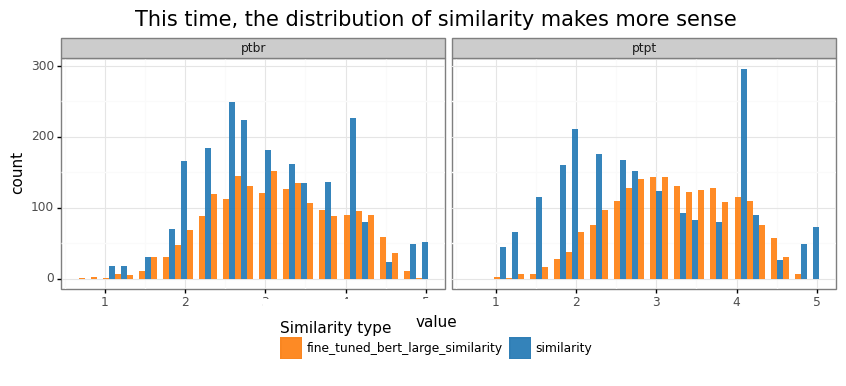

<ggplot: (8774824468420)>

In [232]:
plot_df = pd.melt(test_df, id_vars=["id", "t", "h", "language", "set"])

g = (ggplot(plot_df, aes(x='value', fill='variable')) +
     geom_histogram(binwidth=0.15, alpha=0.9, position="dodge") + 
     theme_bw() + 
     theme(figure_size=(10, 3),
           plot_title=element_text(size=15),
           legend_position="bottom") +
     scale_fill_manual(name="Similarity type", values=["tab:orange", "tab:blue"]) +
     facet_grid(". ~ language", scales="free_y") +
     ggtitle("This time, the distribution of similarity makes more sense"))

g

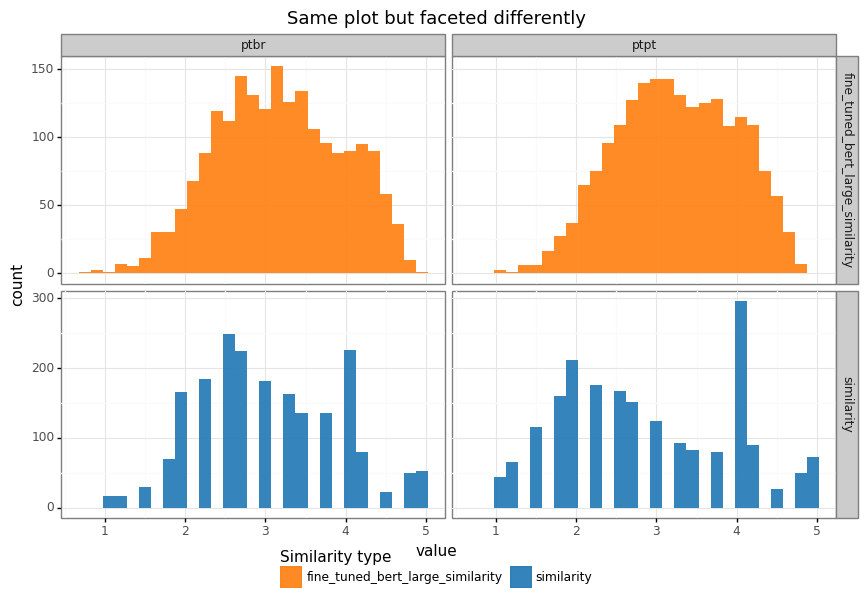

<ggplot: (8774850580565)>

In [237]:
g = (ggplot(plot_df, aes(x='value', fill='variable')) +
     geom_histogram(binwidth=0.15, alpha=0.9, position="dodge") + 
     theme_bw() + 
     theme(figure_size=(10, 6),
           plot_title=element_text(size=13),
           legend_position="bottom") +
     scale_fill_manual(name="Similarity type", values=["tab:orange", "tab:blue"]) +
     facet_grid("variable ~ language", scales="free_y") +
     ggtitle("Same plot but faceted differently"))

g

# Good vs Bad Predictions

Where did this model go wrong? Where did it get it right? What can we learn from this black box?

## True Similarity = 5 | ✅ Good predictions | 🇧🇷 PT-BR

In [244]:
test_df[(test_df["language"] == "ptbr") & (test_df["similarity"] == 5)]\
    .sort_values(["fine_tuned_bert_large_similarity"], ascending=False)\
    .set_index(test_df.columns.tolist()).head()

,,,,,,
id,t,h,similarity,language,set,fine_tuned_bert_large_similarity
391,Os ingressos custam entre R$ 100 e R$ 650.,Os preços dos ingressos variam entre R$ 100 e R$ 650.,5.0,ptbr,test,4.879697
329,"A cerimônia, que ocorrerá no Palácio do Planalto, está prevista para ter início às 15h.",A cerimônia está prevista para começar às 15h e será realizada no Palácio do Planalto.,5.0,ptbr,test,4.856287
135,"Ele falou que estava à disposição, então o trouxemos para cá.",Ele disse que estava à disposição e por isso o trouxemos para cá.,5.0,ptbr,test,4.832805
32,Esta proposta aborda o aumento persistente dos gastos ao longo dos anos.,Essa proposta trata do aumento persistente em despesas ao longo dos anos.,5.0,ptbr,test,4.795143
1936,"Neste domingo, o Atlético-MG recebe o Flamengo às 16 horas no Independência.","O Atlético-MG enfrenta o Flamengo nesse domingo, às 16 h no estádio Independência.",5.0,ptbr,test,4.767831


## True Similarity = 5 | ⛔ Bad predictions | 🇧🇷 PT-BR

In [246]:
test_df[(test_df["language"] == "ptbr") & (test_df["similarity"] == 5)]\
    .sort_values(["fine_tuned_bert_large_similarity"], ascending=True)\
    .set_index(test_df.columns.tolist()).head()

,,,,,,
id,t,h,similarity,language,set,fine_tuned_bert_large_similarity
1596,Somente o presidente da República e o vice poderão viajar de primeira classe.,Viajar de avião na primeira classe agora é exclusividade do presidente e do vice.,5.0,ptbr,test,3.504598
154,Nunca antes um pontífice havia ido ao plenário das Casa Legislativas dos Estados Unidos.,Ele será o primeiro papa no plenário da Casa Legislativa dos Estados Unidos.,5.0,ptbr,test,3.525558
1197,"Até o término do julgamento, outros ministros que já votaram podem mudar suas posições.",Os ministros podem rever votos antes do fim do julgamento.,5.0,ptbr,test,4.018155
201,"Além de Luciana Lóssio, o presidente do TSE, Dias Toffoli, precisa apresentar seu voto.","Além de Lóssio, falta votar o presidente do tribunal, Dias Toffoli.",5.0,ptbr,test,4.022967
1014,Já cortamos aproximadamente dois mil policiais nos últimos oito anos e seis meses.,Cortamos quase 2 mil policiais em 8 anos e 6 meses de governo.,5.0,ptbr,test,4.107897


## True Similarity = 1 | ✅ Good predictions | 🇧🇷 PT-BR

In [247]:
test_df[(test_df["language"] == "ptbr") & (test_df["similarity"] == 1)]\
    .sort_values(["fine_tuned_bert_large_similarity"], ascending=True)\
    .set_index(test_df.columns.tolist()).head()

,,,,,,
id,t,h,similarity,language,set,fine_tuned_bert_large_similarity
1670,"Faturou também a Supercopa da Libertadores e a Recopa no mesmo ano, e a Conmebol de 1994.",Ele assinou contrato até dezembro de 2016.,1.0,ptbr,test,0.849535
1353,Mas as verificações só podem começar no dia 5.,"Por volta das 9h, fizemos uma pausa.",1.0,ptbr,test,0.954918
1098,"A informação foi revelada pelo diretor-presidente da Ancine, Manoel Rangel.",Nós não oneramos o caixa da União.,1.0,ptbr,test,1.154470
1530,"Nada é proibido, mas na seleção brasileira não é local para exposição religiosa ou política.","Não tem nada ganho no Brasileiro, completou Elias.",1.0,ptbr,test,1.229794
14,"A decisão representa uma derrota para o presidente da Câmara, Eduardo Cunha (PMDB-RJ).",Vou entregar as informações.,1.0,ptbr,test,1.250176


## True Similarity = 1 | ⛔ Bad predictions | 🇧🇷 PT-BR

In [249]:
test_df[(test_df["language"] == "ptbr") & (test_df["similarity"] == 1)]\
    .sort_values(["fine_tuned_bert_large_similarity"], ascending=False)\
    .set_index(test_df.columns.tolist()).head()

,,,,,,
id,t,h,similarity,language,set,fine_tuned_bert_large_similarity
801,"A partir de terça, haverá atendimento normalmente até sábado, das 7 às 18 horas.","No sábado, as obras paralisam das 0h às 14h.",1.0,ptbr,test,2.989966
195,Ninguém gosta de sair da Vila Belmiro.,Aquela partida da Vila Belmiro foi muito bem disputada.,1.0,ptbr,test,2.553423
1806,A indústria extrativa exibe comportamento totalmente distinto do setor de transformação.,O início de ano exibe comportamento de queda para além da volatilidade.,1.0,ptbr,test,2.270746
405,"E depois que o francês saiu da lateral esquerda, o Bayer Leverkusen não criou mais perigo.","Também me lembrei de outro texto, falando sobre a lateral esquerda.",1.0,ptbr,test,2.225190
482,Temos que estar muito bem preparados para isso.,Está totalmente recuperado e pronto para voltar a jogar.,1.0,ptbr,test,2.223529


# Overview of misclassification

In [256]:
test_df["similarity_bands"] = pd.cut(test_df["similarity"], range(6))
test_df["ft_bert_similarity_bands"] = pd.cut(test_df["fine_tuned_bert_large_similarity"], range(6))

In [255]:
df_crosstab = pd.crosstab(test_df["similarity_bands"], test_df["ft_bert_similarity_bands"])

df_crosstab.style.background_gradient(cmap='Blues')

ft_bert_similarity_bands,"(0, 1]","(1, 2]","(2, 3]","(3, 4]","(4, 5]"
similarity_bands,,,,,
"(0, 1]",2,23,35,1,0
"(1, 2]",2,127,543,158,4
"(2, 3]",1,46,745,649,15
"(3, 4]",0,4,101,731,373
"(4, 5]",0,0,1,97,342
